In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [32]:
# ===== 文件路径 =====
from typing import Any


emotion_path = "merged_emotion_encoder_output.parquet"
text_path = "merged_text_filled.parquet"
stock_path = "stock_encoder_2324.parquet"
label_ref_path = "all_stock_data_2324.parquet"
output_path = "merged.parquet"

# ===== 1️⃣ 读取数据 =====
print("📥 读取文件中...")
emotion = pd.read_parquet(emotion_path)
text = pd.read_parquet(text_path)
stock = pd.read_parquet(stock_path)
label_ref = pd.read_parquet(label_ref_path)

stock = stock[~stock['Date'].astype(str).str.startswith('2022')]
stock = stock[
    ~(
        (stock["StockCode"].isin(["000768", "301269", "601012"])) & 
        (stock["Date"].astype(str).str.startswith("2023"))
    )
]

# ===== 2️⃣ 标准化列名 =====
def standardize(df):
    if "Date" not in df.columns:
        for c in df.columns:
            if c.lower() == "date" or c.lower() == "mapped_date":
                df.rename(columns={c: "Date"}, inplace=True)
    if "StockCode" not in df.columns:
        for c in df.columns:
            if "stock" in c.lower():
                df.rename(columns={c: "StockCode"}, inplace=True)
                df['StockCode'] = df['StockCode'].astype(str).str.zfill(6)
    df["Date"] = pd.to_datetime(df["Date"], format="mixed", dayfirst=True, errors="coerce")
    df["StockCode"] = df["StockCode"].astype(str)
    return df

emotion = standardize(emotion)
text = standardize(text)
stock = standardize(stock)

# ===== 3️⃣ Label 文件处理 =====
label_ref.rename(columns={
    "日期": "Date",
    "股票代码": "StockCode",
    "收盘": "Close",
    "涨跌幅": "PctChange"
}, inplace=True)
label_ref["Date"] = pd.to_datetime(label_ref["Date"], format="mixed", dayfirst=True, errors="coerce")
label_ref["StockCode"] = label_ref["StockCode"].astype(str).str.zfill(6)

# 生成下一条涨跌率标签
print("📈 生成标签（基于下一交易日涨跌）...")
label_ref = label_ref.sort_values(["StockCode", "Date"])
label_ref["next_pct"] = label_ref.groupby("StockCode")["PctChange"].shift(-1)

def label_func(pct):
    threshold = 0.5
    if pd.isna(pct):
        return np.nan
    if pct > threshold:
        return 2  # 涨
    elif pct < -threshold:
        return 0  # 跌
    else:
        return 1  # 平

label_ref["Label"] = label_ref["next_pct"].apply(label_func)
label_ref = label_ref.dropna(subset=["Label"])
label_ref["Label"] = label_ref["Label"].astype(int)
# ===== 4️⃣ 取三源交集 =====
print("🔗 计算三源交集 (Date, StockCode)...")
keys_stock = set(zip(stock["Date"], stock["StockCode"]))
keys_emotion = set(zip(emotion["Date"], emotion["StockCode"]))
keys_text = set(zip(text["Date"], text["StockCode"]))
valid_keys = keys_stock & keys_emotion & keys_text
print(f"✅ 三源交集样本数: {len(valid_keys):,}")

valid_df = pd.DataFrame(list[tuple](valid_keys), columns=["Date", "StockCode"])

# ===== 5️⃣ 筛选并合并所有源 =====
print("🔄 合并 stock + emotion + text + label...")
stock = stock.merge(valid_df, on=["Date", "StockCode"], how="inner")
emotion = emotion.merge(valid_df, on=["Date", "StockCode"], how="inner")
text = text.merge(valid_df, on=["Date", "StockCode"], how="inner")

merged = (
    stock.merge(emotion, on=["Date", "StockCode"], how="inner")
         .merge(text, on=["Date", "StockCode"], how="inner")
         .merge(label_ref[["Date", "StockCode", "Label"]], on=["Date", "StockCode"], how="left")
)
merged = merged.dropna(subset=["Label"]).reset_index(drop=True)
print(f"✅ 合并后共有 {len(merged):,} 行, {merged.shape[1]} 列")

# ===== 6️⃣ 类型优化与压缩 =====
float_cols = merged.select_dtypes(include=["float64"]).columns
merged[float_cols] = merged[float_cols].astype("float32")

📥 读取文件中...
📈 生成标签（基于下一交易日涨跌）...
🔗 计算三源交集 (Date, StockCode)...
✅ 三源交集样本数: 110,265
🔄 合并 stock + emotion + text + label...
✅ 合并后共有 110,035 行, 2073 列


In [33]:
df = merged

# 检查 Label 列存在
if "Label" not in df.columns:
    raise ValueError("❌ 文件中未找到 'Label' 列，请检查列名。")

# 打印转换前类型
print(f"转换前 Label 类型: {df['Label'].dtype}")

# 转为 int32
df["Label"] = df["Label"].astype("int32")

# 打印转换后类型
print(f"✅ 转换后 Label 类型: {df['Label'].dtype}")

# 保存为压缩 Parquet
df.to_parquet(output_path, index=False, compression="zstd", compression_level=9)

print(f"💾 已保存转换后的文件至: {output_path}")

转换前 Label 类型: float32
✅ 转换后 Label 类型: int32
💾 已保存转换后的文件至: merged.parquet


# Merging

In [3]:
import pandas as pd
import glob

In [4]:
files = sorted(glob.glob('../data/pack/processed_emo_2/parquet/*.parquet'))
senti_df = pd.read_parquet(files)

In [14]:
senti_df.rename(columns={'mapped_date': 'date'}, inplace=True)

In [15]:
senti_df.to_parquet('merged_emotion_encoder_output.parquet')

In [9]:
files = sorted(glob.glob('../data/processed_text_ref2024/parquet/*.parquet'))
text_df = pd.read_parquet(files)

In [17]:
text_df.rename(columns={'mapped_date': 'date'}, inplace=True)

In [18]:
text_df.to_parquet('merged_text_filled.parquet')

# Validate Merged

In [1]:
import pandas as pd
df = pd.read_parquet('merged.parquet')

In [2]:
df

,Date,StockCode,log_return,amplitude,rsi_14,macd,bb_width_20,obv,Total_Positive_closing,Total_Positive_trading,...,dim_1019_trading,dim_1020_closing,dim_1020_trading,dim_1021_closing,dim_1021_trading,dim_1022_closing,dim_1022_trading,dim_1023_closing,dim_1023_trading,Label
0,2024-01-02,000001,-0.006369,0.013845,47.947865,-0.077915,0.070875,-570910.0,5.0,38.0,...,0.027384,-0.010439,-0.012125,-0.029876,-0.029982,0.029978,0.029064,0.009652,0.013536,1
1,2024-01-03,000001,-0.019355,0.022801,40.591137,-0.076021,0.061919,-1729276.0,9.0,25.0,...,0.031408,-0.009831,-0.010095,-0.030475,-0.026553,0.031489,0.029393,0.008786,0.014202,0
2,2024-01-04,000001,-0.001086,0.007609,40.221912,-0.074468,0.057991,-2462886.0,34.0,40.0,...,0.031000,-0.004802,-0.011902,-0.030113,-0.028916,0.039048,0.032483,0.016083,0.008540,2
3,2024-01-05,000001,-0.009831,0.012075,36.963131,-0.079582,0.053254,-3327080.0,37.0,71.0,...,0.027916,0.000094,-0.009069,-0.025414,-0.031841,0.042790,0.033477,0.013781,0.011540,0
4,2024-01-08,000001,0.017411,0.039914,45.428070,-0.069919,0.048988,-1335458.0,55.0,84.0,...,0.030817,-0.036634,-0.029876,-0.022743,-0.021115,0.039488,0.029569,0.013702,0.009635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55376,2024-12-24,688981,0.009501,0.058836,62.324966,0.245546,0.155387,5433623.0,20.0,47.0,...,0.022533,-0.003446,-0.012176,-0.035018,-0.031648,0.054779,0.038949,0.012411,0.011070,2
55377,2024-12-25,688981,0.017497,0.044910,64.317863,0.927912,0.179688,6345668.0,33.0,58.0,...,0.020155,-0.011004,-0.013854,-0.031011,-0.027213,0.042726,0.032780,0.009424,0.009520,0
55378,2024-12-26,688981,0.011599,0.034902,65.634621,1.542098,0.205059,7330997.0,15.0,31.0,...,0.023582,-0.007651,-0.013114,-0.028597,-0.029145,0.045538,0.028628,0.018354,0.015277,2
55379,2024-12-27,688981,-0.012942,0.028223,62.849564,1.905210,0.219481,6619951.0,40.0,93.0,...,0.019170,-0.007509,-0.017059,-0.036172,-0.029715,0.049050,0.037995,0.010759,0.012893,2


In [3]:
date_dict = {}
for idx, sub_df in df.groupby(['StockCode']):
    date_dict[sub_df['StockCode'].iloc[0]] = len(sub_df)

In [4]:
date_dict

{'000001': 241,
 '000002': 241,
 '000063': 241,
 '000301': 241,
 '000333': 241,
 '000338': 241,
 '000568': 241,
 '000596': 241,
 '000630': 241,
 '000651': 241,
 '000661': 241,
 '000708': 241,
 '000768': 241,
 '000776': 241,
 '000786': 241,
 '000792': 241,
 '000800': 241,
 '000807': 241,
 '000876': 241,
 '000895': 241,
 '000938': 241,
 '000963': 241,
 '000977': 241,
 '000983': 241,
 '000999': 241,
 '001289': 241,
 '001979': 241,
 '002001': 241,
 '002027': 241,
 '002049': 241,
 '002050': 241,
 '002142': 241,
 '002179': 241,
 '002180': 241,
 '002230': 241,
 '002236': 241,
 '002241': 241,
 '002252': 234,
 '002304': 241,
 '002311': 241,
 '002352': 241,
 '002371': 241,
 '002422': 241,
 '002460': 241,
 '002466': 241,
 '002475': 241,
 '002493': 241,
 '002600': 241,
 '002601': 241,
 '002648': 241,
 '002714': 241,
 '002916': 241,
 '002920': 241,
 '002938': 241,
 '003816': 241,
 '300014': 241,
 '300015': 241,
 '300033': 241,
 '300059': 241,
 '300274': 241,
 '300308': 241,
 '300316': 241,
 '300347

In [5]:
tot_days = 0
for k,v in date_dict.items():
    tot_days += v

In [6]:
tot_days

55381

In [25]:
dates = sub_df['Date'].tolist()

In [34]:
for code in date_dict:
    if date_dict[code] != 241:
        print(code, len(dates) - date_dict[code])
        missing_dates = sorted((set(dates) - set(df[df['StockCode'] == code]['Date'].tolist())))
        print([x.strftime('%Y-%m-%d') for x in missing_dates])

002252 7
['2024-12-20', '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-30']
600150 10
['2024-09-03', '2024-09-04', '2024-09-05', '2024-09-06', '2024-09-09', '2024-09-10', '2024-09-11', '2024-09-12', '2024-09-13', '2024-09-18']
600482 10
['2024-10-28', '2024-10-29', '2024-10-30', '2024-10-31', '2024-11-01', '2024-11-04', '2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08']
600584 5
['2024-03-20', '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26']
601211 17
['2024-09-06', '2024-09-09', '2024-09-10', '2024-09-11', '2024-09-12', '2024-09-13', '2024-09-18', '2024-09-19', '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25', '2024-09-26', '2024-09-27', '2024-09-30', '2024-10-08', '2024-10-09']


In [24]:
df[df['StockCode'] == '002252']

,Date,StockCode,log_return,amplitude,rsi_14,macd,bb_width_20,obv,Total_Positive_closing,Total_Positive_trading,...,dim_1019_trading,dim_1020_closing,dim_1020_trading,dim_1021_closing,dim_1021_trading,dim_1022_closing,dim_1022_trading,dim_1023_closing,dim_1023_trading,Label
8917,2024-01-02,002252,0.006270,0.020000,36.558014,-0.052116,0.075369,33090.0,24.0,73.0,...,0.026177,-0.020004,-0.016998,-0.033633,-0.030946,0.024660,0.017844,0.010012,0.007305,2
8918,2024-01-03,002252,-0.046044,0.132199,25.789246,-0.081724,0.092914,-2046678.0,12.0,23.0,...,0.023766,-0.009783,-0.019018,-0.036392,-0.031559,0.029507,0.019630,0.003529,0.011820,2
8919,2024-01-04,002252,0.019443,0.059050,34.453064,-0.092024,0.099584,-944060.0,10.0,16.0,...,0.029417,-0.009896,-0.014901,-0.031045,-0.032265,0.034471,0.020147,0.004821,0.004808,1
8920,2024-01-05,002252,0.005122,0.044700,36.579372,-0.095854,0.103519,-250407.0,10.0,11.0,...,0.027795,-0.013726,-0.012589,-0.029882,-0.031190,0.036796,0.026245,0.002268,0.009216,0
8921,2024-01-08,002252,-0.002558,0.029449,35.951393,-0.099358,0.105829,-774041.0,5.0,14.0,...,0.030600,-0.010817,-0.022460,-0.028912,-0.031251,0.029530,0.023620,0.005535,0.007633,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9146,2024-12-13,002252,0.009109,0.020725,61.145599,0.033032,0.046291,6244385.0,2.0,7.0,...,0.024253,-0.015335,-0.021942,-0.037366,-0.023416,0.030033,0.020472,0.009618,0.014969,0
9147,2024-12-16,002252,-0.028911,0.038667,49.127293,0.026183,0.045646,5258179.0,2.0,1.0,...,0.021769,-0.017135,-0.023298,-0.030853,-0.034250,0.025990,0.023181,0.020433,0.003503,0
9148,2024-12-17,002252,-0.010724,0.018868,45.616146,0.014136,0.046278,4728063.0,1.0,5.0,...,0.020509,-0.021394,-0.028655,-0.023953,-0.030951,0.012685,0.008923,-0.001406,-0.003134,0
9149,2024-12-18,002252,-0.014936,0.016416,41.250557,-0.004238,0.052675,4303830.0,5.0,3.0,...,0.032062,-0.012061,-0.013766,-0.025365,-0.025967,0.020883,0.025249,0.000689,0.006963,1


# Corr

In [1]:
import pandas as pd
df = pd.read_parquet('merged.parquet')

In [3]:
df.drop(columns = [x for x in df.columns if x.startswith('dim')], inplace=True)

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df

,Date,StockCode,log_return,amplitude,rsi_14,macd,bb_width_20,obv,Total_Positive_closing,Total_Positive_trading,Total_Negative_closing,Total_Negative_trading,Total_Neutral_closing,Total_Neutral_trading,Total_Posts_closing,Total_Posts_trading,Total_Click_Count_closing,Total_Click_Count_trading,Emotion_Index_closing,Emotion_Index_trading,Emotion_Momentum_3d_closing,Emotion_Momentum_3d_trading,Emotion_Momentum_5d_closing,Emotion_Momentum_5d_trading,Label
0,2024-01-02,000001,-0.006369,0.013845,47.947865,-0.077915,0.070875,-570910.0,5.0,38.0,29.0,72.0,15.0,39.0,49.000000,149.0,16602.000000,30489.0,-0.705882,-0.309091,-0.705882,-0.309091,-0.705882,-0.309091,1
1,2024-01-03,000001,-0.019355,0.022801,40.591137,-0.076021,0.061919,-1729276.0,9.0,25.0,12.0,32.0,10.0,43.0,31.000000,100.0,8579.000000,18293.0,-0.142857,-0.122807,-0.424370,-0.215949,-0.424370,-0.215949,1
2,2024-01-04,000001,-0.001086,0.007609,40.221912,-0.074468,0.057991,-2462886.0,34.0,40.0,29.0,63.0,34.0,36.0,97.000000,139.0,27698.000000,22094.0,0.079365,-0.223301,-0.256458,-0.218400,-0.256458,-0.218400,1
3,2024-01-05,000001,-0.009831,0.012075,36.963131,-0.079582,0.053254,-3327080.0,37.0,71.0,11.0,30.0,25.0,45.0,42.146568,146.0,11615.709961,32000.0,0.541667,0.405941,0.159392,0.019944,-0.056927,-0.062315,1
4,2024-01-08,000001,0.017411,0.039914,45.428070,-0.069919,0.048988,-1335458.0,55.0,84.0,58.0,64.0,31.0,36.0,144.000000,184.0,30028.000000,22202.0,-0.026549,0.135135,0.198161,0.105925,-0.050851,-0.022825,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55376,2024-12-24,688981,0.009501,0.058836,62.324966,0.245546,0.155387,5433623.0,20.0,47.0,4.0,24.0,8.0,25.0,32.000000,96.0,14903.000000,22391.0,0.666667,0.323944,0.468620,0.364650,0.407668,0.241198,1
55377,2024-12-25,688981,0.017497,0.044910,64.317863,0.927912,0.179688,6345668.0,33.0,58.0,6.0,27.0,17.0,32.0,56.000000,117.0,26683.000000,22415.0,0.692308,0.364706,0.555032,0.347010,0.530745,0.352601,1
55378,2024-12-26,688981,0.011599,0.034902,65.634621,1.542098,0.205059,7330997.0,15.0,31.0,6.0,21.0,14.0,30.0,35.000000,82.0,16261.000000,18681.0,0.428571,0.192308,0.595849,0.293652,0.505348,0.330193,1
55379,2024-12-27,688981,-0.012942,0.028223,62.849564,1.905210,0.219481,6619951.0,40.0,93.0,22.0,33.0,46.0,54.0,62.353828,180.0,39357.390625,37828.0,0.290323,0.476190,0.470401,0.344401,0.476798,0.341906,1


In [11]:
label_ref_path = "all_stock_data_sorted.csv"
label_ref = pd.read_csv(label_ref_path)

In [12]:
label_ref.rename(columns={
    "日期": "Date",
    "股票代码": "StockCode",
    "收盘": "Close",
    "涨跌幅": "PctChange"
}, inplace=True)
label_ref["Date"] = pd.to_datetime(label_ref["Date"], format="mixed", dayfirst=True, errors="coerce")
label_ref["StockCode"] = label_ref["StockCode"].astype(str).str.zfill(6)

label_ref = label_ref.sort_values(["StockCode", "Date"])
label_ref["next_pct"] = label_ref.groupby("StockCode")["PctChange"].shift(-1)

In [13]:
label_ref

,Date,StockCode,开盘,Close,最高,最低,成交量,成交额,振幅,PctChange,涨跌额,next_pct
0,2023-12-01,000001,9.65,9.66,9.68,9.58,778057,7.496684e+08,1.03,-0.21,-0.02,-0.31
1,2023-12-04,000001,9.67,9.63,9.68,9.61,605438,5.836643e+08,0.72,-0.31,-0.03,-1.56
2,2023-12-05,000001,9.61,9.48,9.62,9.47,787378,7.509612e+08,1.56,-1.56,-0.15,0.21
3,2023-12-06,000001,9.44,9.50,9.57,9.40,753056,7.140295e+08,1.79,0.21,0.02,-0.63
4,2023-12-07,000001,9.49,9.44,9.49,9.38,585380,5.522248e+08,1.16,-0.63,-0.06,-1.48
...,...,...,...,...,...,...,...,...,...,...,...,...
60436,2024-12-25,688981,96.48,97.99,99.80,96.38,985329,9.679610e+09,3.53,1.17,1.13,-1.29
60437,2024-12-26,688981,98.00,96.73,98.88,96.15,711046,6.914605e+09,2.79,-1.29,-1.26,0.81
60438,2024-12-27,688981,96.78,97.51,102.37,96.49,1144716,1.137894e+10,6.08,0.81,0.78,1.83
60439,2024-12-30,688981,96.60,99.29,100.53,96.00,906573,8.950495e+09,4.65,1.83,1.78,-4.70


In [22]:
merged_df = pd.merge(df, label_ref[['StockCode', 'Date', 'next_pct']], how='left', on=['StockCode', 'Date'])
merged_df.drop(columns= ['Date', 'StockCode', 'Label'], inplace=True)

In [ ]:
merged_df

,log_return,amplitude,rsi_14,macd,bb_width_20,obv,Total_Positive_closing,Total_Positive_trading,Total_Negative_closing,Total_Negative_trading,Total_Neutral_closing,Total_Neutral_trading,Total_Posts_closing,Total_Posts_trading,Total_Click_Count_closing,Total_Click_Count_trading,Emotion_Index_closing,Emotion_Index_trading,Emotion_Momentum_3d_closing,Emotion_Momentum_3d_trading,Emotion_Momentum_5d_closing,Emotion_Momentum_5d_trading,next_pct
0,-0.006369,0.013845,47.947865,-0.077915,0.070875,-570910.0,5.0,38.0,29.0,72.0,15.0,39.0,49.000000,149.0,16602.000000,30489.0,-0.705882,-0.309091,-0.705882,-0.309091,-0.705882,-0.309091,-0.11
1,-0.019355,0.022801,40.591137,-0.076021,0.061919,-1729276.0,9.0,25.0,12.0,32.0,10.0,43.0,31.000000,100.0,8579.000000,18293.0,-0.142857,-0.122807,-0.424370,-0.215949,-0.424370,-0.215949,-0.98
2,-0.001086,0.007609,40.221912,-0.074468,0.057991,-2462886.0,34.0,40.0,29.0,63.0,34.0,36.0,97.000000,139.0,27698.000000,22094.0,0.079365,-0.223301,-0.256458,-0.218400,-0.256458,-0.218400,1.76
3,-0.009831,0.012075,36.963131,-0.079582,0.053254,-3327080.0,37.0,71.0,11.0,30.0,25.0,45.0,42.146568,146.0,11615.709961,32000.0,0.541667,0.405941,0.159392,0.019944,-0.056927,-0.062315,-1.29
4,0.017411,0.039914,45.428070,-0.069919,0.048988,-1335458.0,55.0,84.0,58.0,64.0,31.0,36.0,144.000000,184.0,30028.000000,22202.0,-0.026549,0.135135,0.198161,0.105925,-0.050851,-0.022825,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55376,0.009501,0.058836,62.324966,0.245546,0.155387,5433623.0,20.0,47.0,4.0,24.0,8.0,25.0,32.000000,96.0,14903.000000,22391.0,0.666667,0.323944,0.468620,0.364650,0.407668,0.241198,1.17
55377,0.017497,0.044910,64.317863,0.927912,0.179688,6345668.0,33.0,58.0,6.0,27.0,17.0,32.0,56.000000,117.0,26683.000000,22415.0,0.692308,0.364706,0.555032,0.347010,0.530745,0.352601,-1.29
55378,0.011599,0.034902,65.634621,1.542098,0.205059,7330997.0,15.0,31.0,6.0,21.0,14.0,30.0,35.000000,82.0,16261.000000,18681.0,0.428571,0.192308,0.595849,0.293652,0.505348,0.330193,0.81
55379,-0.012942,0.028223,62.849564,1.905210,0.219481,6619951.0,40.0,93.0,22.0,33.0,46.0,54.0,62.353828,180.0,39357.390625,37828.0,0.290323,0.476190,0.470401,0.344401,0.476798,0.341906,1.83


In [26]:
corr_with_next_pct = merged_df.corr()["next_pct"].sort_values(ascending=False)
print("Correlation of each column with next_pct:")
print(corr_with_next_pct)


Correlation of each column with next_pct:
next_pct                       1.000000
amplitude                      0.049565
log_return                     0.045348
Emotion_Index_closing          0.038692
Emotion_Index_trading          0.021268
Emotion_Momentum_3d_closing    0.018642
Total_Positive_trading         0.018509
Total_Positive_closing         0.014487
Total_Neutral_trading          0.013109
Emotion_Momentum_3d_trading    0.011757
Total_Posts_trading            0.009969
rsi_14                         0.009410
Emotion_Momentum_5d_closing    0.008581
Total_Click_Count_trading      0.006067
Emotion_Momentum_5d_trading    0.005904
Total_Neutral_closing          0.000096
bb_width_20                   -0.001312
Total_Click_Count_closing     -0.002448
Total_Posts_closing           -0.005440
Total_Negative_trading        -0.005819
macd                          -0.008136
Total_Negative_closing        -0.008334
obv                           -0.009030
Name: next_pct, dtype: float64


In [31]:
corr_with_next_pct.iloc[:10].index.tolist()

['next_pct',
 'amplitude',
 'log_return',
 'Emotion_Index_closing',
 'Emotion_Index_trading',
 'Emotion_Momentum_3d_closing',
 'Total_Positive_trading',
 'Total_Positive_closing',
 'Total_Neutral_trading',
 'Emotion_Momentum_3d_trading']

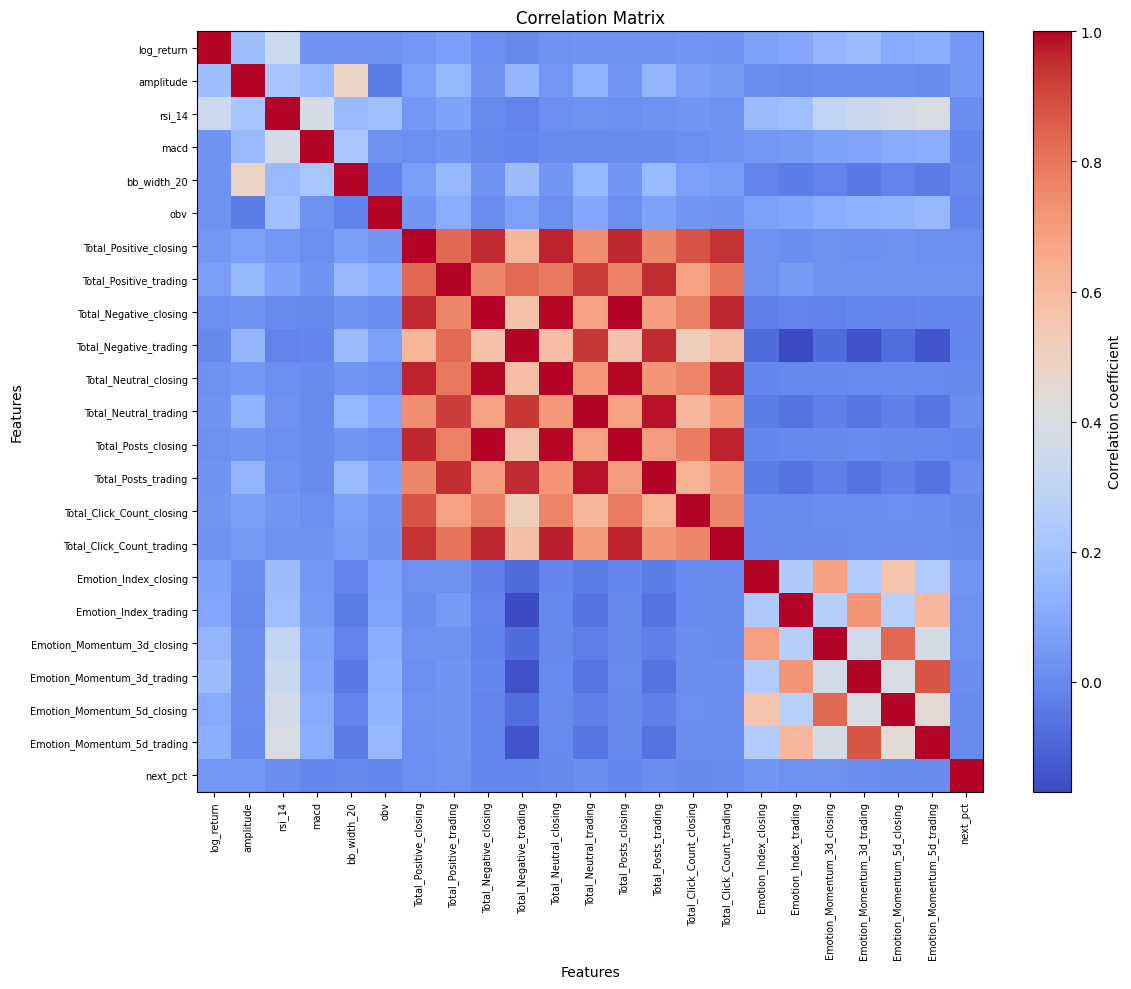

In [25]:
import matplotlib.pyplot as plt
import numpy as np

corr = merged_df.corr()
plt.figure(figsize=(12, 10))
im = plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(im, label='Correlation coefficient')
plt.title('Correlation Matrix')

# Show column names as ticks
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
plt.yticks(np.arange(len(corr.columns)), corr.columns, fontsize=7)
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# Merge

In [1]:
import pandas as pd
import glob

In [17]:
stock = pd.read_parquet('stock_encoder_2324.parquet')
stock = stock[~stock['Date'].astype(str).str.startswith('2022')]
stock = stock[
    ~(
        (stock["StockCode"].isin(["000768", "301269", "601012"])) & 
        (stock["Date"].astype(str).str.startswith("2023"))
    )
]

keys_stock = set(zip(stock["Date"].dt.date, stock["StockCode"]))

In [27]:
stock

,Date,StockCode,log_return,amplitude,rsi_14,macd,bb_width_20,obv
22,2023-01-03,000001,0.009928,0.024316,40.131297,-0.029623,0.070856,515120.0
23,2023-01-04,000001,0.045310,0.058097,52.066549,0.028866,0.078128,2709248.0
24,2023-01-05,000001,0.039165,0.055168,59.840436,0.118237,0.108137,4898931.0
25,2023-01-06,000001,0.011111,0.025552,61.782246,0.199673,0.136059,6564356.0
26,2023-01-09,000001,0.009622,0.016416,63.447673,0.272369,0.161541,7760101.0
...,...,...,...,...,...,...,...,...
115921,2024-12-25,688981,0.017497,0.044910,64.317864,0.927912,0.179688,24844504.0
115922,2024-12-26,688981,0.011599,0.034902,65.634624,1.542098,0.205059,25829833.0
115923,2024-12-27,688981,-0.012942,0.028223,62.849563,1.905210,0.219481,25118787.0
115924,2024-12-30,688981,0.008031,0.060302,63.871583,2.230211,0.234477,26263503.0


In [18]:
files = sorted(glob.glob('../data/senti_text_process/processed_emo_2324/parquet/*.parquet'))
df = pd.read_parquet(files)

In [26]:
df

,stockbar_code,mapped_date,Total_Positive_closing,Total_Positive_trading,Total_Negative_closing,Total_Negative_trading,Total_Neutral_closing,Total_Neutral_trading,Total_Posts_closing,Total_Posts_trading,Total_Click_Count_closing,Total_Click_Count_trading,Emotion_Index_closing,Emotion_Index_trading,Emotion_Momentum_3d_closing,Emotion_Momentum_3d_trading,Emotion_Momentum_5d_closing,Emotion_Momentum_5d_trading
0,000001,2023-01-03,16.0,42.0,3.0,17.0,11.0,23.0,30.000000,82.0,25665.00000,62530.0,0.684211,0.423729,0.684211,0.423729,0.684211,0.423729
1,000001,2023-01-04,14.0,46.0,7.0,17.0,9.0,28.0,30.000000,91.0,33734.00000,62096.0,0.333333,0.460317,0.508772,0.442023,0.508772,0.442023
2,000001,2023-01-05,5.0,29.0,3.0,15.0,9.0,15.0,17.000000,59.0,12876.00000,45572.0,0.250000,0.318182,0.422515,0.400743,0.422515,0.400743
3,000001,2023-01-06,9.0,28.0,6.0,14.0,13.0,17.0,16.165808,59.0,18274.29072,54106.0,0.200000,0.333333,0.261111,0.370611,0.366886,0.383890
4,000001,2023-01-09,11.0,20.0,0.0,17.0,6.0,13.0,17.000000,50.0,20741.00000,44384.0,1.000000,0.081081,0.483333,0.244199,0.493509,0.323329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110986,688981,2024-12-25,33.0,58.0,6.0,27.0,17.0,32.0,56.000000,117.0,26683.00000,22415.0,0.692308,0.364706,0.555032,0.347010,0.530745,0.352601
110987,688981,2024-12-26,15.0,31.0,6.0,21.0,14.0,30.0,35.000000,82.0,16261.00000,18681.0,0.428571,0.192308,0.595849,0.293652,0.505348,0.330193
110988,688981,2024-12-27,40.0,93.0,22.0,33.0,46.0,54.0,62.353829,180.0,39357.39050,37828.0,0.290323,0.476190,0.470401,0.344401,0.476798,0.341906
110989,688981,2024-12-30,25.0,68.0,6.0,24.0,12.0,40.0,43.000000,132.0,14717.00000,20114.0,0.612903,0.478261,0.443932,0.382253,0.538154,0.367082


In [45]:
df.to_parquet('merged_emotion_encoder_output.parquet')

In [21]:
files = sorted(glob.glob('../data/processed_text_ref2023/parquet/*.parquet'))
df23 = pd.read_parquet(files)
# files = sorted(glob.glob('../data/processed_text_ref2024/parquet/*.parquet'))
df24 = pd.read_parquet('../model/merged_text_filled.parquet')
df24.rename(columns={"date": "mapped_date"}, inplace=True)
df_text = pd.concat((df23, df24))

In [25]:
df_text

,stockbar_code,mapped_date,dim_0_closing,dim_0_trading,dim_1_closing,dim_1_trading,dim_2_closing,dim_2_trading,dim_3_closing,dim_3_trading,...,dim_1019_closing,dim_1019_trading,dim_1020_closing,dim_1020_trading,dim_1021_closing,dim_1021_trading,dim_1022_closing,dim_1022_trading,dim_1023_closing,dim_1023_trading
0,000001,2023-01-03,-0.012908,-0.014214,0.010551,0.009296,-0.013228,-0.011359,0.000546,-0.003169,...,0.031319,0.027051,-0.010947,-0.013249,-0.027605,-0.027146,0.032901,0.033775,0.011165,0.013913
1,000001,2023-01-04,-0.009935,-0.012501,0.011575,0.012749,-0.017469,-0.013892,0.003946,0.001756,...,0.022570,0.027971,-0.015008,-0.013451,-0.019158,-0.029692,0.030122,0.029546,0.002516,0.012407
2,000001,2023-01-05,-0.006871,-0.005005,0.014135,0.020071,-0.011070,-0.016222,0.003438,-0.000019,...,0.014774,0.030549,-0.007652,-0.014746,-0.022870,-0.025559,0.031440,0.028084,0.003854,0.007787
3,000001,2023-01-06,-0.012901,-0.011277,0.011668,0.013091,-0.019287,-0.020488,-0.003348,0.002158,...,0.029458,0.031349,0.000496,-0.008756,-0.026722,-0.029390,0.035923,0.037295,0.013639,0.011186
4,000001,2023-01-09,-0.018856,-0.015273,0.010541,0.016700,-0.023354,-0.014062,0.005285,0.005482,...,0.029165,0.027346,-0.011578,-0.016485,-0.024602,-0.028068,0.032115,0.034931,0.001952,0.010951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55606,688981,2024-12-25,-0.007857,-0.005495,0.007583,0.005897,-0.023154,-0.017869,-0.000502,-0.003548,...,0.022939,0.020155,-0.011004,-0.013854,-0.031011,-0.027213,0.042726,0.032780,0.009424,0.009520
55607,688981,2024-12-26,-0.010417,-0.005927,-0.000088,0.004598,-0.024551,-0.020483,0.006375,-0.006230,...,0.019036,0.023582,-0.007651,-0.013114,-0.028597,-0.029145,0.045538,0.028628,0.018354,0.015277
55608,688981,2024-12-27,-0.013425,-0.007854,0.008314,0.006863,-0.030121,-0.022257,-0.003099,-0.004296,...,0.023244,0.019170,-0.007509,-0.017059,-0.036172,-0.029715,0.049050,0.037995,0.010759,0.012893
55609,688981,2024-12-30,-0.006319,-0.010631,0.010852,0.001682,-0.024463,-0.017772,0.002558,0.000400,...,0.016155,0.020722,-0.015278,-0.018552,-0.019973,-0.025895,0.043763,0.041567,0.012104,0.009148


In [28]:
df_text.to_parquet('merged_text_filled.parquet')

In [20]:
(keys_stock - set(zip(df["mapped_date"], df["stockbar_code"])))

set()

In [23]:
len(keys_stock - set(zip(df_text["mapped_date"], df_text["stockbar_code"])))

0